# Visualize the physical parameters and data fitting

The first cell is a copy of the inversion code 

In [15]:
import os
os.environ['TZ'] = 'GMT'
os.environ["OMP_NUM_THREADS"] = "4"

import h5py
import emcee
import corner
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15

from tqdm import tqdm
from MCMC_func import *
from multiprocessing import Pool, cpu_count
from das_util import read_decimate, get_tstamp
from emcee.ensemble import EnsembleSampler

ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

csv_file = pd.read_csv('NewportSalop_merged.csv', low_memory=False)

with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture_dts.hdf5', 'r') as f:
    interp_cc = f['cc'][:]
    interp_temp10 = f['temperature10'][:]
    interp_temp0 = f['temperature0'][:]
    interp_humidity = f['moisture'][:]
    ave_psd = f['psd_rain'][:]
    
with h5py.File('/fd1/QibinShi_data/England_farm/interp_dvv_temp_moisture.hdf5', 'r') as f:
    interp_dvv = f['dvv_refined'][:]
    
with h5py.File('/fd1/QibinShi_data/England_farm/psd_all.hdf5', 'r') as f:
    file_list = f['daslist'][:].astype('U')
acqu_time = np.array([get_tstamp(i) for i in file_list])
unix_tvec = np.array([x.timestamp for x in acqu_time])

# format is: (initial value, [vmin, vmax])
modelparam = {
            "a0"            : (0.0, [-5.0, 5.0]), # offset
            "p1"            : (-0.05, [-10, 0.0]), # scale of GWL 
            "a_{precip}"      : (5e-1, [0, 1.0]), # delay in GWL [1/hour]
            "p2"            : (1, [0, 20]), # scale of Temp
            "t_{shiftdays}"   : (0.1, [0, 10]), # shift of temp in 1 sec
            "p3"            : (1, [0, 20]), # scale of Temp
            "log_f"         : (0.0, [-10, 10]), # magnitude of uncertainity
            }

# plt.close('all')
# plt.figure(figsize = (18, 5), dpi = 100)
# plt.scatter(np.arange(2408), (interp_temp0[8]-5)/60, marker='o', s=0.1, edgecolors='k')
# plt.scatter(np.arange(2408), (interp_temp0[16]-5)/60, marker='o', s=0.1, edgecolors='r')
# plt.scatter(np.arange(2408), (interp_temp0[24]-5)/60, marker='o', s=0.1, edgecolors='g')
# plt.scatter(np.arange(2408), (interp_temp10-7.5)/20, marker='o', s=0.1, edgecolors='b')
# plt.ylabel("temperature (C)", fontsize = 20)
# plt.xlabel("Date and Time", fontsize = 20)

112 CPUs


In [40]:
a_all = []
p1_all = []
p3_all = []


for ch in range(43):

    file="./processed_data/MCMC_sampler/no_cc/MCMC_sampler_Ch"+ str(ch) +"_25_50Hz_evap.pickle"

    # Open the pickle file for reading in binary mode
    with open(file, 'rb') as file:
        sampler = pickle.load(file)

    tau = sampler.get_autocorr_time(tol=10, quiet=True)
    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
    log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
#     log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

    print("burn-in: {0}".format(burnin))
    print("thin: {0}".format(thin))
    print("flat chain shape: {0}".format(samples.shape))
    print("flat log prob shape: {0}".format(log_prob_samples.shape))
#     print("flat log prior shape: {0}".format(log_prior_samples.shape))

    all_samples = np.concatenate((samples, log_prob_samples[:, None]), axis=1)

    labels =  ['a0', 'p1', 'a_{precip}', 'p2', 't_{shiftseconds}', 'p3', 'log_f']
    labels += ["log prob"]

#     corner.corner(all_samples, labels=labels)

    modelparam["fixparam01"] = False
    modelparam["nsteps"] = 5000
    modelparam["nwalkers"] = 32

    modelparam["precip"] = ave_psd * 3.5
    modelparam["CAVG"] = (interp_temp10-7.5)/20
    modelparam["surface_temp"] = (interp_temp0[0]-5)/60
    modelparam["a_{precip}_fixed"] = 0.02426

    modelparam["averagestack_step"] = 1
    modelparam["uniform_tvec"] = acqu_time
    modelparam["unix_tvec"] = unix_tvec

    modelparam["modelcase"] = "evap"
    pos, ndim, keys = get_init_param(**modelparam)
    if modelparam["fixparam01"]:
        pos_fixed = np.delete(pos, [keys.index("a_{precip}")], 1)
        modelparam["pos"] = pos_fixed
        modelparam["ndim"] = ndim - 1
    else:
        modelparam["pos"] = pos
        modelparam["ndim"] = ndim

    max_prob_index = np.argmax(log_prob_samples)
    optimized_params = samples[max_prob_index]
    model = model_evap(optimized_params, **modelparam)

#     x=np.arange(len(model))

#     plt.figure(figsize=(18, 5))
#     plt.scatter(x, interp_dvv[ch]-np.mean(interp_dvv[ch]), cmap='viridis', c=interp_cc[ch], s=40, marker='o')
#     plt.scatter(x, model, color='k', s=10, marker='o')
#     bar=plt.colorbar()
#     bar.set_label('Cross-correlation Coefficient', fontsize = 15)
#     plt.title('Channel '+str(ch))
#     plt.ylim(-0.5,0.5)
    
    a0, p1, a, p2, t_shift, p3, log_f= optimized_params
    
    a_all.append(a)
    p1_all.append(p1)
    p3_all.append(p3)

burn-in: 568
thin: 63
flat chain shape: (2240, 7)
flat log prob shape: (2240,)
burn-in: 527
thin: 78
flat chain shape: (1824, 7)
flat log prob shape: (1824,)
burn-in: 730
thin: 72
flat chain shape: (1888, 7)
flat log prob shape: (1888,)
burn-in: 449
thin: 73
flat chain shape: (1984, 7)
flat log prob shape: (1984,)
burn-in: 555
thin: 89
flat chain shape: (1568, 7)
flat log prob shape: (1568,)
burn-in: 482
thin: 84
flat chain shape: (1696, 7)
flat log prob shape: (1696,)
burn-in: 558
thin: 64
flat chain shape: (2208, 7)
flat log prob shape: (2208,)
burn-in: 453
thin: 72
flat chain shape: (2016, 7)
flat log prob shape: (2016,)
burn-in: 629
thin: 64
flat chain shape: (2176, 7)
flat log prob shape: (2176,)
burn-in: 517
thin: 81
flat chain shape: (1760, 7)
flat log prob shape: (1760,)
burn-in: 593
thin: 63
flat chain shape: (2208, 7)
flat log prob shape: (2208,)
burn-in: 605
thin: 54
flat chain shape: (2592, 7)
flat log prob shape: (2592,)
burn-in: 623
thin: 44
flat chain shape: (3168, 7)
fl

N/10 = 500;
tau: [343.838654   281.79793345 190.92476729 192.83773643 303.08873187
 352.02204837 504.73952993]


burn-in: 1009
thin: 95
flat chain shape: (1344, 7)
flat log prob shape: (1344,)
burn-in: 576
thin: 62
flat chain shape: (2272, 7)
flat log prob shape: (2272,)
burn-in: 708
thin: 62
flat chain shape: (2208, 7)
flat log prob shape: (2208,)
burn-in: 401
thin: 33
flat chain shape: (4448, 7)
flat log prob shape: (4448,)
burn-in: 509
thin: 50
flat chain shape: (2848, 7)
flat log prob shape: (2848,)
burn-in: 872
thin: 66
flat chain shape: (1984, 7)
flat log prob shape: (1984,)
burn-in: 601
thin: 84
flat chain shape: (1664, 7)
flat log prob shape: (1664,)
burn-in: 660
thin: 66
flat chain shape: (2080, 7)
flat log prob shape: (2080,)
burn-in: 525
thin: 85
flat chain shape: (1664, 7)
flat log prob shape: (1664,)
burn-in: 600
thin: 85
flat chain shape: (1632, 7)
flat log prob shape: (1632,)
burn-in: 580
thin: 76
flat chain shape: (1856, 7)
flat log prob shape: (1856,)
burn-in: 549
thin: 69
flat chain shape: (2048, 7)
flat log prob shape: (2048,)
burn-in: 623
thin: 82
flat chain shape: (1696, 7)
f

In [41]:
a_all = np.array(a_all)
p1_all = np.array(p1_all)
p3_all = np.array(p3_all)

Text(0, 0.5, 'temp coefficient')

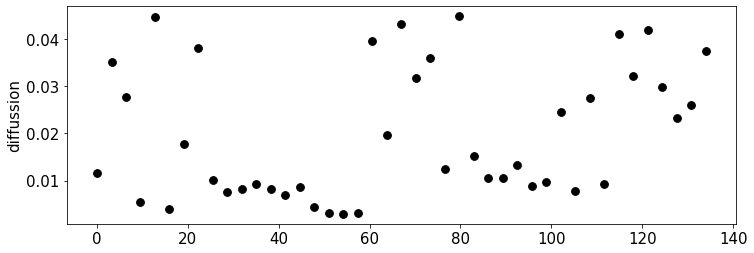

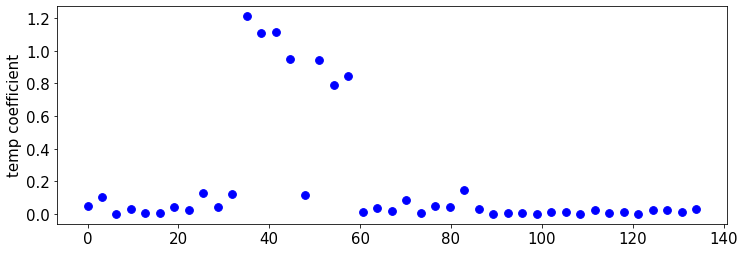

In [44]:
plt.figure(figsize=(12, 4))
plt.scatter( np.arange(43)*3.19,a_all, color='k', s=60, marker='o')
plt.ylabel('diffussion')

plt.figure(figsize=(12, 4))
plt.scatter( np.arange(43)*3.19,p3_all, color='b', s=60, marker='o')
plt.ylabel('temp coefficient')

In [11]:
dvv_data_trim = interp_dvv[ch]-np.mean(interp_dvv[ch])
err_data_trim = (1-interp_cc[ch])*2
cc = np.nansum(np.multiply(dvv_data_trim, model))
n1 = np.nansum(np.square(dvv_data_trim))
n2 = np.nansum(np.square(model))
cc = cc / np.sqrt(n1 * n2)

a0, p1, a, p2, t_shift, p3, log_f= optimized_params

sigma2 = err_data_trim ** 2 + model ** 2 * np.exp(2 * log_f)

prob1= -0.5 * np.nansum((dvv_data_trim - model) ** 2 / sigma2 + np.log(sigma2*2*np.pi))
prob2= (cc - 1) * np.nansum(sigma2)

print(prob1, prob2)


-1720.0569705661733 -279.7042658091252


In [76]:
print(log_f)
print(max_prob_index)
print(log_prob_samples[max_prob_index])

-4.466832427358046
2310
216.02043789455342


(-0.5, 0.5)

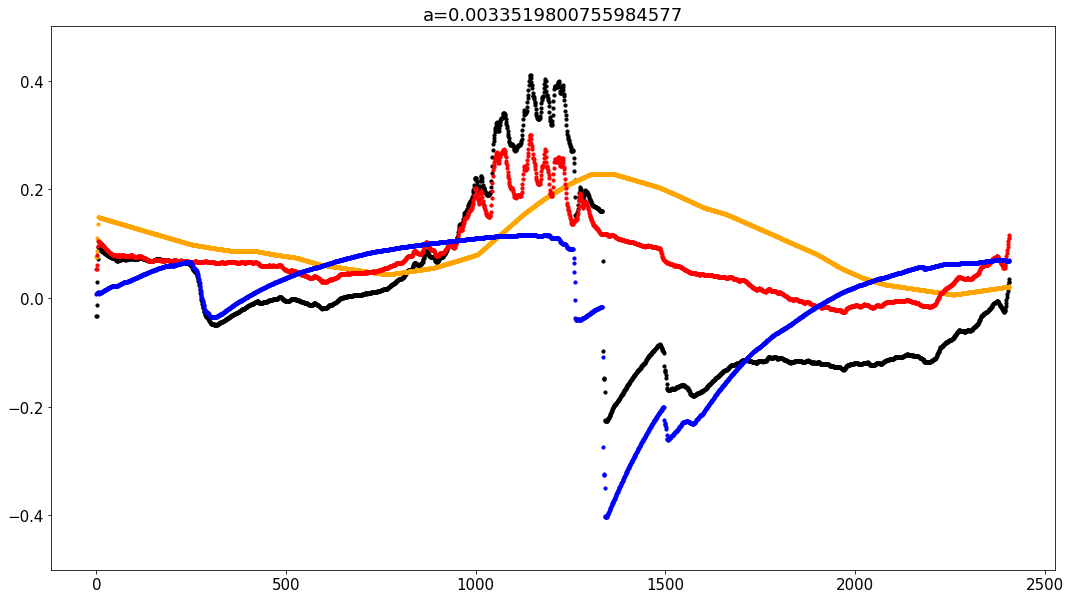

In [18]:
a0, p1, a, p2, t_shift, p3, log_f= optimized_params

# for a in [1, 0.1, 0.01, 0.001]:

precip = np.array(modelparam["precip"])/1e2
phi = 0.05
Nprecip = len(precip)
expij = [np.exp(-(a*modelparam["averagestack_step"])*x) for x in range(Nprecip)]
GWL = np.convolve(expij, precip - np.mean(precip), mode='full')[:Nprecip] / phi
GWL = GWL - np.mean(GWL)

unix_tvec = modelparam["unix_tvec"]
smooth_temp10 = np.convolve(modelparam["CAVG"], np.ones(6)/6, mode='same')
smooth_temp0 = np.convolve(modelparam["surface_temp"], np.ones(6)/6, mode='same')
T_shift10 = np.interp(unix_tvec - t_shift*1, unix_tvec, smooth_temp10)
T_shift0 = np.interp(unix_tvec - t_shift*1, unix_tvec, smooth_temp0)

model_all = a0 + p1 * GWL + p2 * T_shift10 + p3 * T_shift0

plt.figure(figsize=(18, 10))
plt.scatter(x, model_all, color='k', s=10, marker='o')

plt.scatter(x, T_shift10*p2, color='orange', s=10, marker='o')
plt.scatter(x, T_shift0*p3, color='r', s=10, marker='o')

plt.scatter(x, GWL*p1, color='b', s=10, marker='o')

plt.title('a='+str(a))
plt.ylim(-0.5,0.5)

0.9084454823157241